In [1]:
# Install the plugin
# !pip install -e .

In [2]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import random_clifford
from qiskit.transpiler import PassManager

from qiskit_ibm_transpiler.ai.collection import CollectCliffords
from qiskit_ibm_transpiler.ai.synthesis import AICliffordSynthesis

In [3]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

coupling_map = QiskitRuntimeService().backend("ibm_cairo").coupling_map

## Step 1: Create your circuit

Original circuit -> Depth: 90, Gates(2q): 136


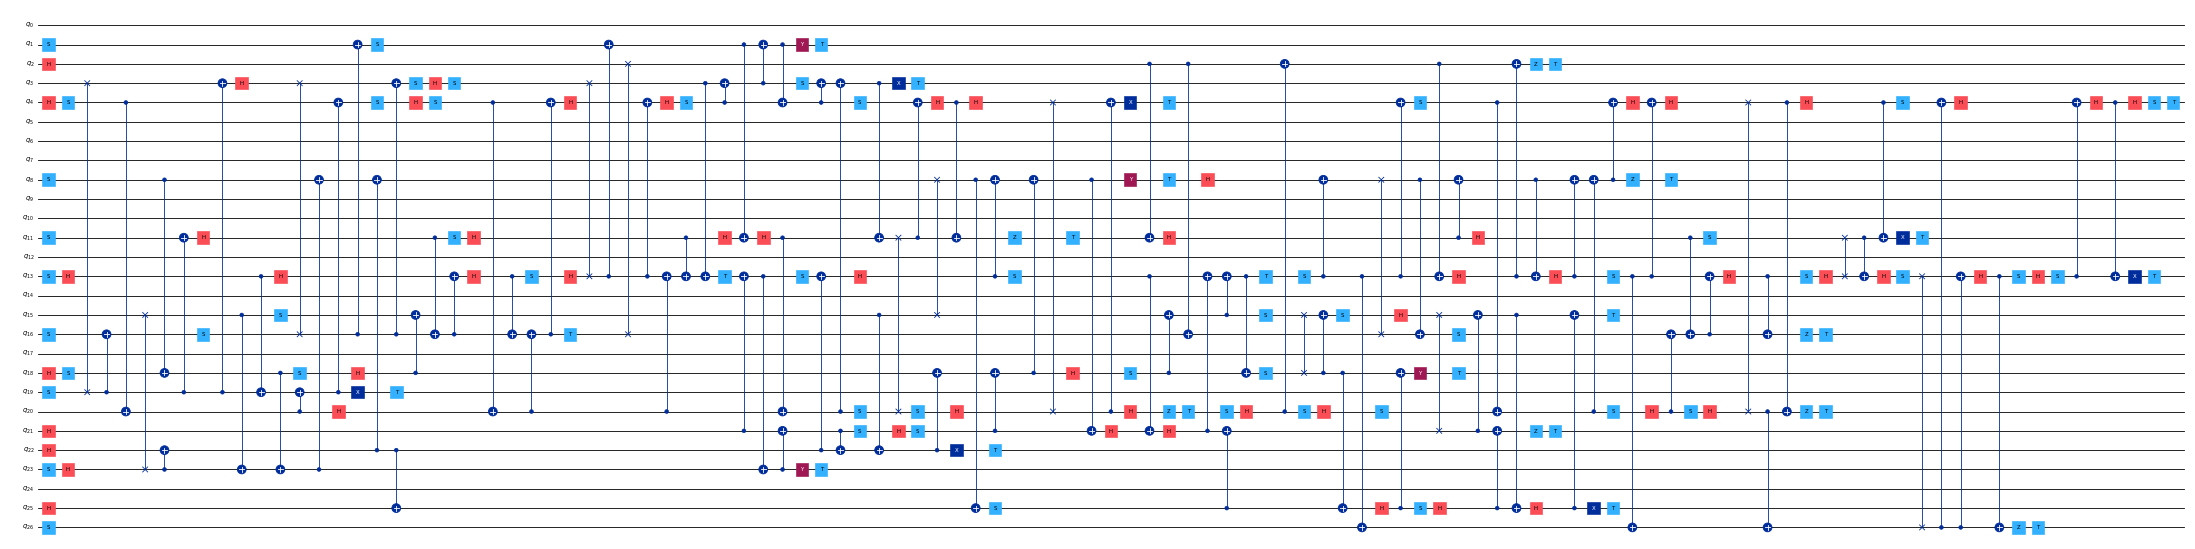

In [4]:
circuit = QuantumCircuit(27)

for c in range(3):
    nq = 8
    qs = np.random.choice(range(circuit.num_qubits), size=nq, replace=False)
    circuit.compose(random_clifford(nq).to_circuit(), qubits=qs.tolist(), inplace=True)
    for q in qs:
        circuit.t(q)

print(
    f"Original circuit -> Depth: {circuit.decompose(reps=3).depth()}, "
    "Gates(2q): {circuit.decompose(reps=3).num_nonlocal_gates()}"
)
circuit.draw(output="mpl", fold=-1, scale=0.3, style="iqp")

## Step 2: Optimize your circuit

#### Transpile the circuit

In [5]:
qiskit_lvl3_transpiler = generate_preset_pass_manager(
    optimization_level=3, coupling_map=coupling_map
)

In [6]:
lvl3_transp_circuit = qiskit_lvl3_transpiler.run(circuit)

Qiskit lvl3 Transpiler -> Depth: 222, Gates(2q): 321


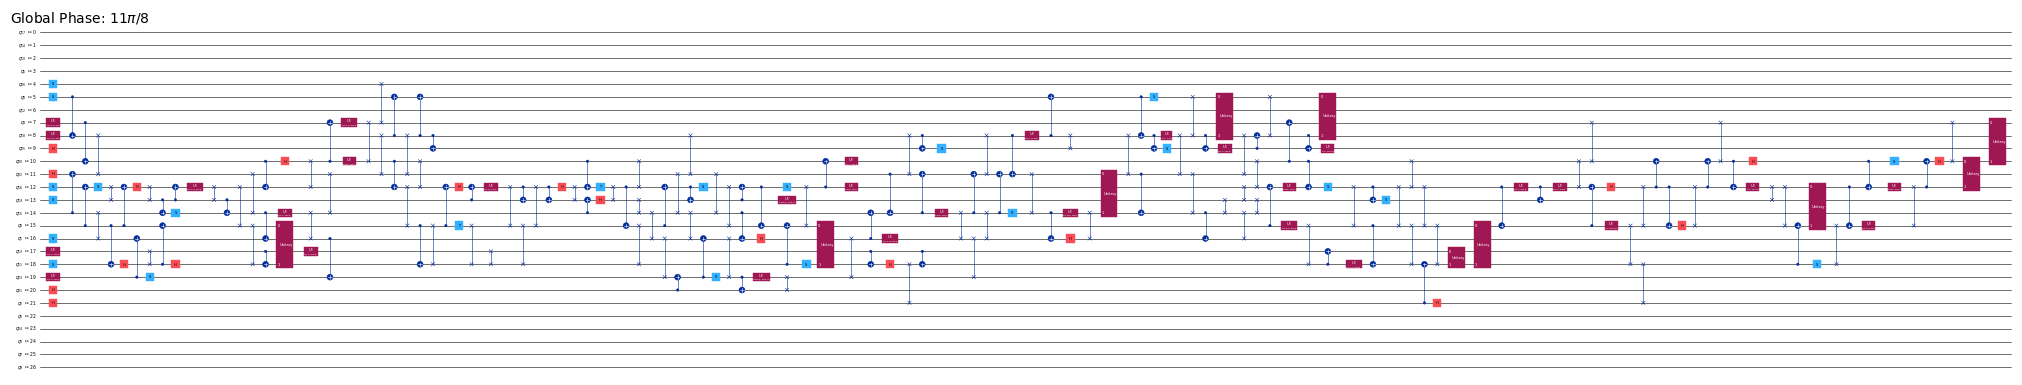

In [7]:
print(
    f"Qiskit lvl3 Transpiler -> Depth: {lvl3_transp_circuit.decompose(reps=3).depth()}"
    f", Gates(2q): {lvl3_transp_circuit.decompose(reps=3).num_nonlocal_gates()}"
)
lvl3_transp_circuit.draw(output="mpl", fold=-1, scale=0.2, style="iqp")

#### Further optimization with AI Synthesis passes

In [8]:
ai_optimize_cliffords = PassManager(
    [
        CollectCliffords(),
        AICliffordSynthesis(backend_name="ibm_canberra"),
    ]
)

In [9]:
# AI Synthesis passes respect the coupling map and should run after transpiling
ai_optimized_circuit = ai_optimize_cliffords.run(lvl3_transpiled_circuit)

INFO:qiskit_ibm_transpiler.ai.synthesis:Requesting synthesis to the service
ERROR:qiskit_ibm_transpiler.wrappers.base:No model available for the requested subgraph
ERROR:qiskit_ibm_transpiler.wrappers.base:No model available for the requested subgraph


AI-Optimized circuit -> Depth: 193, Gates(2q): 278


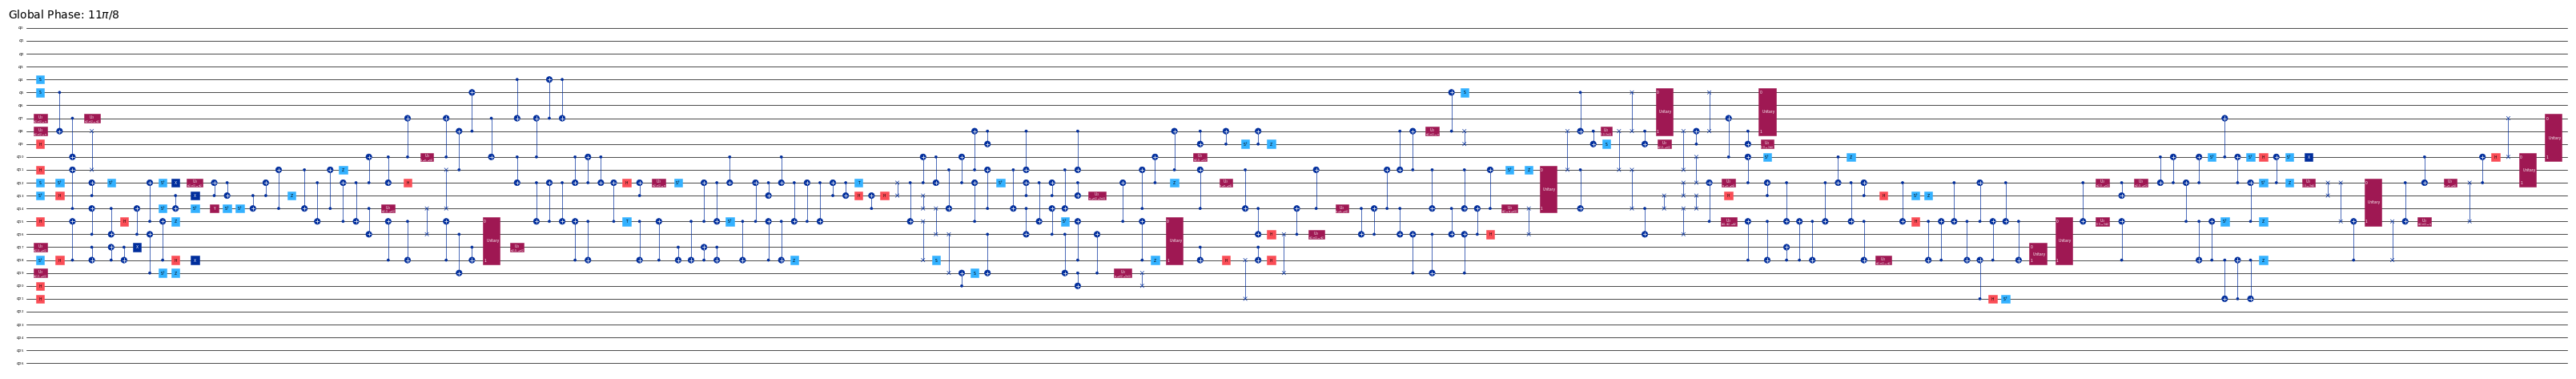

In [10]:
print(
    f"AI-Optimized circuit -> Depth: {ai_optimized_circuit.decompose(reps=3).depth()}, "
    f"Gates(2q): {ai_optimized_circuit.decompose(reps=3).num_nonlocal_gates()}"
)
ai_optimized_circuit.draw(output="mpl", fold=-1, scale=0.25, style="iqp")